<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/backdoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U daft
!pip install japanize_matplotlib

In [ ]:
#@title import pkg
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import daft
import japanize_matplotlib
import matplotlib.pyplot as plt

plt.style.use(
    "ggplot"
)  
import seaborn as sns


In [3]:
%matplotlib inline


# Definition : Backdoor Criterion
A set of variables W satisfies the backdoor criterion relative to T and Y if the following are true:

- W blocks all backdoor paths from T to Y.
- W does not contain any descendants of T. <br>
(引用) : Introduction to Causal Inference



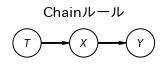

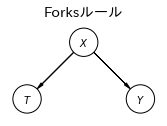

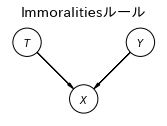

In [4]:
#@title 3変数のDAGをまず考えてみよう { display-mode: "form" }
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 0))
pgm.add_node(daft.Node("X", r"$X$", 1, 0))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 0))
# Edges
pgm.add_edge("T", "X")
pgm.add_edge("X", "Y")

pgm.render()
plt.title("Chainルール")
plt.show()

########
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 0))
pgm.add_node(daft.Node("X", r"$X$", 1, 1))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 0))

# Edges
pgm.add_edge("X", "T")
pgm.add_edge("X", "Y")

pgm.render()
plt.title("Forksルール")
plt.show()
#########
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 1))
pgm.add_node(daft.Node("X", r"$X$", 1, 0))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 1))

# Edges
pgm.add_edge("T", "X")
pgm.add_edge("Y", "X")

pgm.render()
plt.title("Immoralitiesルール")
plt.show()

#### Chain ルール
仮に真のDAGがChainルールだった場合、

In [6]:
#@title 真の効果を６と設定
n_points = 1000
true_t_coef = 3
true_x_coef = 2
print("真のt->yの効果は: ", true_t_coef * true_x_coef)

np.random.seed(seed=1)
t = np.random.normal(0, 50, size=n_points)

x = np.random.normal(0, 100, size=n_points) + t * true_t_coef

y = np.random.normal(0, 200, size=n_points) + x * true_x_coef

data = np.stack([t, x, y]).T
chain_df = pd.DataFrame(data, columns=["t", "x", "y"])
chain_df.head()

真のt->yの効果は:  6


,t,x,y
0,81.217268,228.328188,554.559700
1,-30.587821,-335.014313,-622.269455
2,-26.408588,-28.427329,-146.477020
3,-53.648431,-193.348526,-508.856053
4,43.270381,-21.296516,-448.582047


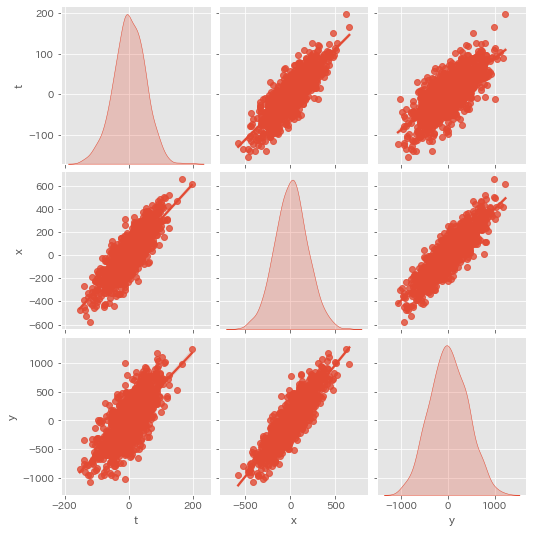

In [7]:
sns.pairplot(data=chain_df, kind="reg", diag_kind="kde")

In [8]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=chain_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.2428,8.825,0.141,0.888,-16.075,18.561
t,5.8910,0.180,32.768,0.000,5.538,6.244


In [9]:
# 介入変数Tと中間変数Xで回帰したとき
regression = smf.ols("y ~ t + x", data=chain_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.8896,6.150,-0.632,0.527,-15.959,8.179
t,-0.0227,0.221,-0.103,0.918,-0.456,0.410
x,1.9416,0.060,32.545,0.000,1.824,2.059


 - 中間変数Xで条件つけた場合（観察した場合＝回帰係数に入れた場合）、TとYは独立になる

$$
    % align環境を使うと複数の式を&で位置合わせできる
    \begin{align*}
        P(T, X, Y) &= P(T) P(X|T) P(Y|X) \\
        P(T, Y | X) &= \frac{P(T) P(X|T) P(Y|X) }{ P(X) }  \\ 
                   &=  P(T|X) P(Y|X)
    \end{align*}
$$   

X の条件付き独立 $ T \perp\kern-5pt\perp Y \mid X$

#### Fork ルール
- 仮に真のDAGがChainルールだった場合、関心のある因果効果T->Yはどうすれば識別できるのか

In [11]:
#@title 真の効果は6
n_points = 1000
true_xt_coef = 3
true_xy_coef = -20
true_ty_coef = 6
print("真のt->yの効果は: ", true_ty_coef)

np.random.seed(seed=1)
x = np.random.normal(0, 3, size=n_points)

t = np.random.normal(0, 2, size=n_points) + x * true_xt_coef

y = np.random.normal(0, 20, size=n_points) + x * true_xy_coef + t * true_ty_coef

data = np.stack([t, x, y]).T
fork_df = pd.DataFrame(data, columns=["t", "x", "y"])
fork_df.head()

真のt->yの効果は:  6


,t,x,y
0,14.312636,4.873036,-1.794574
1,-10.370825,-1.835269,-20.743647
2,-3.737577,-1.584515,0.302606
3,-10.304782,-3.218906,-9.666476
4,4.766515,2.596223,-63.924266


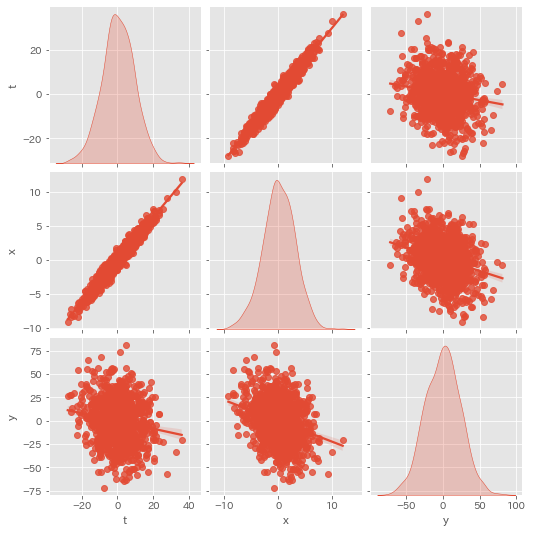

In [15]:
sns.pairplot(data=fork_df, kind="reg", diag_kind="kde")

In [16]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1811,0.739,-0.245,0.806,-1.631,1.269
t,-0.4141,0.081,-5.110,0.000,-0.573,-0.255


In [17]:
# 介入変数Tと共変量Xで回帰したとき
regression = smf.ols("y ~ t + x", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3890,0.615,-0.632,0.527,-1.596,0.818
t,5.7078,0.298,19.135,0.000,5.122,6.293
x,-19.4535,0.923,-21.069,0.000,-21.265,-17.642


In [18]:
# @title
# xで条件付けしてみる
def conditon_x_plot(df):
    """
    共変量Xを９分割して、各クラス内で単回帰してみる
    実質的に粗い重回帰になっている
    """
    df["class_x"] = pd.qcut(df["x"], 9).astype("str")
    cutpoint_list = sorted(df["class_x"].unique())

    list_param = []
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 8))

    ax_list = [item for sublist in ax for item in sublist]  # axはネストしているので、解消しておく
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, cutpoint in enumerate(cutpoint_list):
        _group = df.query("class_x == @cutpoint")
        _regression = smf.ols("y ~ t", data=_group).fit()

        sns.regplot(x="t", y="y", data=_group, ax=ax_list[i], color="b")
        ax_list[i].set_title(f"x class = {cutpoint}", fontsize=12)
        ax_list[i].text(
            0.05,
            0.95,
            f"y = {round(_regression.params[0],2)} + {round(_regression.params[1],2)}*t",
            verticalalignment="top",
            transform=ax_list[i].transAxes,
            fontsize=14,
        )

        if _regression.pvalues[1] <= 0.05:
            list_param.append(_regression.params[1])

    fig.suptitle("x1 vs. x3 | x2", fontsize=16)
    plt.show()

    return np.mean(list_param)

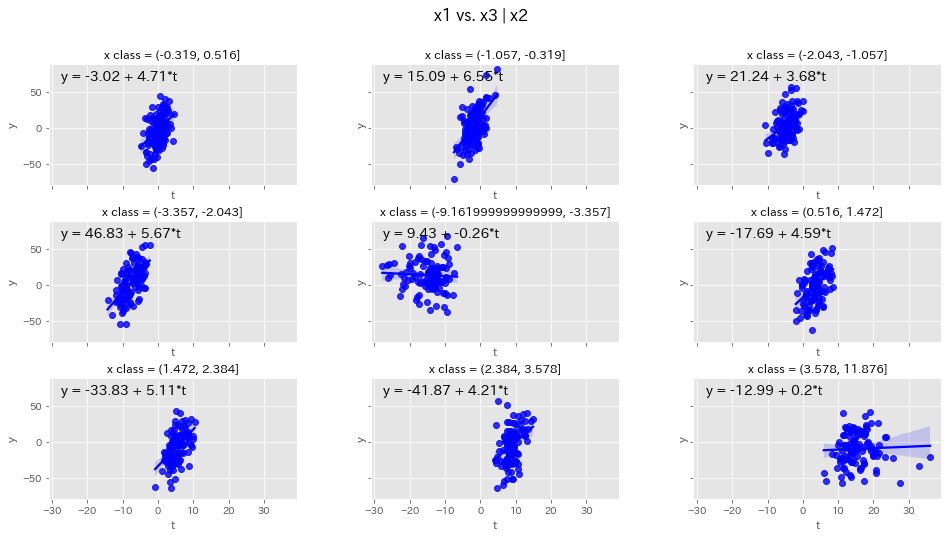

4.932336503451563

In [19]:
conditon_x_plot(fork_df)

- これも自明ではあるが、xで条件つけた場合、tとyは独立になる

$$
    \begin{align*}
        P(t, x, y) &= P(x) P(t|x) P(y|x) \\
        P(t, y | x) &=  P(t|x) P(y|x)
    \end{align*}
$$    
    
    
x の条件付き独立 $ t \perp\kern-5pt\perp y \mid x$

### Immoralitiesルール
- DAGから $ t \perp\kern-5pt\perp y$ は明らか
- $t$と$y$の同時分布　$P(t, y) = P(t) P(y)$
- ただし、共通子孫である$x$を観察した瞬間、$t \not\!\perp\!\!\!\perp y \mid x$となるので注意.
(Xの子孫を観察した場合も同じ)

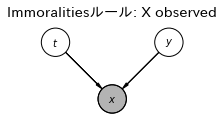

In [20]:
# @title
pgm = daft.PGM()

# Nodes
pgm.add_node(daft.Node("T", r"$t$", 0, 1))
pgm.add_node(daft.Node("X", r"$x$", 1, 0, observed=True))
pgm.add_node(daft.Node("Y", r"$y$", 2, 1))

# Edges
pgm.add_edge("T", "X")
pgm.add_edge("Y", "X")

pgm.render()
plt.title("Immoralitiesルール: X observed")
plt.show()

In [21]:
#@title 真の効果はゼロ
# コリンダーバイアス
n_points = 1000
true_tx_coef = 3
true_yx_coef = 2
print("真のt->yの効果は: ゼロ！")

np.random.seed(seed=1)
t = np.random.normal(0, 50, size=n_points)
y = np.random.normal(0, 30, size=n_points)
x = t * true_tx_coef + y * true_yx_coef

data = np.stack([t, x, y]).T
colliders_df = pd.DataFrame(data, columns=["t", "x", "y"])
colliders_df.head()

真のt->yの効果は: ゼロ！


,t,x,y
0,81.217268,234.457635,-4.597085
1,-30.587821,-237.713973,-72.975255
2,-26.408588,-48.746703,15.239530
3,-53.648431,-180.387233,-9.720970
4,43.270381,39.146548,-45.332298


In [22]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1811,0.739,-0.245,0.806,-1.631,1.269
t,-0.4141,0.081,-5.110,0.000,-0.573,-0.255


In [23]:
# 介入変数Tと共通子孫のみで回帰したとき
regression = smf.ols("y ~ t + x", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3890,0.615,-0.632,0.527,-1.596,0.818
t,5.7078,0.298,19.135,0.000,5.122,6.293
x,-19.4535,0.923,-21.069,0.000,-21.265,-17.642


#### collidersバイアスに注意！
- 相関があるから、なんでもかんでも変数としてもってくればいいわけではない
- $t$と$y$は本来関係なかった（独立）はずなのに、その合流点$x$(もしくは、その子孫ノード)を観察（重回帰の変数として採用）してしまったばっかりに、$t$の係数は有意

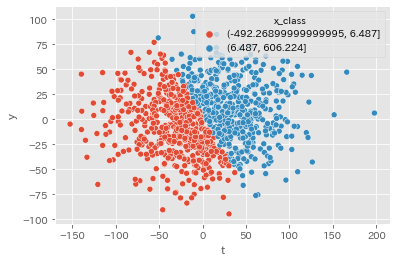

In [24]:
colliders_df["x_class"] = pd.qcut(colliders_df["x"], 2)
sns.scatterplot(x="t", y="y", data=colliders_df, hue="x_class")
plt.show()

# Frontdoor criterion / frontdoor adjustment
### Frontdoor adjustment: big picture
1. Identify the causal effect of T on M
2. Identify the causal effect of M on Y
3. Combine the above steps to identify the causal effect of T on Y

(引用) : [Introduction to Causal Inference](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf)

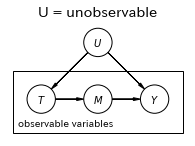

In [26]:
#@title frontdoor
# frontdoor
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U", r"$U$", 2, 2)

pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 2, 1)
pgm.add_node("Y", r"$Y$", 3, 1)

pgm.add_edge("U", "T")
pgm.add_edge("U", "Y")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 3, 1], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U = unobservable")
plt.show()

#### 1. Identify the causal effect of T on M

- T->Mへの回帰でOK

$$
P(m | do(t)) = P(m | t)
$$

#### 2. Identify the causal effect of M on Y

- M->Yへの効果を識別する
- この場合、backdoor M <- T <- U -> Yが開いている状態
- 必ずTで調整する
$$
P(y | do(m)) = \sum_{t} P(y|m,t) P(t)
$$


#### 3. Combine the above steps to identify the causal effect of T on Y

- 1.と2.を掛け合わせる

$$
P(y | do(t)) = \sum_{m} P(m | do(t))P(y | do(m))
$$


真のt->yの効果は:  8


,T,U_unobsevable,M,Y
0,470.294395,162.434536,995.414652,-12270.508117
1,-453.535369,-61.175641,-880.325602,2619.745984
2,-102.065264,-52.817175,-254.319051,4375.881459
3,-357.858175,-107.296862,-784.125391,7755.086135
4,91.892785,86.540763,-43.568277,-8768.656191


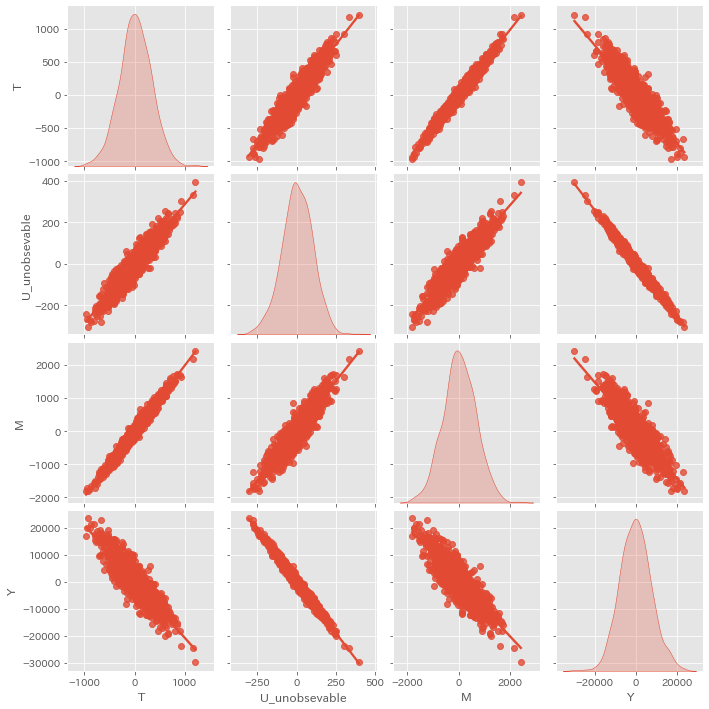

In [28]:
# @title 真の効果 8
n_points = 1000
true_ut_coef = 3
true_uy_coef = -100
true_tm_coef = 2
true_my_coef = 4

print("真のt->yの効果は: ", true_tm_coef * true_my_coef)

np.random.seed(seed=1)
u = np.random.normal(0, 100, size=n_points)

t = np.random.normal(0, 111, size=n_points) + u * true_ut_coef

m = np.random.normal(0, 112, size=n_points) + t * true_tm_coef

y = np.random.normal(0, 113, size=n_points) + u * true_uy_coef + m * true_my_coef

data = np.stack([t, u, m, y]).T
front_df = pd.DataFrame(data, columns=["T", "U_unobsevable", "M", "Y"])

sns.pairplot(data=front_df, kind="reg", diag_kind="kde")
front_df.head()

In [29]:
true_regression = smf.ols("Y ~ T + U_unobsevable", data=front_df).fit()
print(true_regression.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.6625     14.365     -0.603      0.547     -36.851      19.526
T                 7.9080      0.126     62.998      0.000       7.662       8.154
U_unobsevable   -99.8743      0.407   -245.409      0.000    -100.673     -99.076


### frontdoor調整
#### (1) t->m

In [30]:
tm_regression = smf.ols("M ~ T", data=front_df).fit()
# print(tm_regression.summary().tables[1])

tm_coef_estimated = tm_regression.params["T"]
print(f"(1) 想定 t->m: {true_tm_coef}, 推定値 t->m: {tm_coef_estimated}")

(1) 想定 t->m: 2, 推定値 t->m: 1.9800112260227365


#### (2) m->y
- Tで調整することを忘れない

In [31]:
my_regression = smf.ols("Y ~ M + T", data=front_df).fit()

my_coef_estimated = my_regression.params["M"]
print(f"(2) 想定 m->y: {true_my_coef}, 推定値 m->y: {my_coef_estimated}")

(2) 想定 m->y: 4, 推定値 m->y: 3.6897991215128583


#### (3) t->y
- あとは掛け算するだけ

In [32]:
print(
    f"(3) 想定 t->y: {true_tm_coef*true_my_coef}, 推定値 t->y: {tm_coef_estimated*my_coef_estimated}"
)

(3) 想定 t->y: 8, 推定値 t->y: 7.305843682364291


## 総合問題


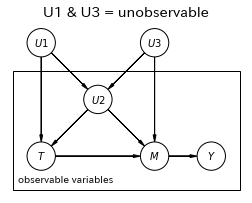

In [33]:
# @title （１）これって識別可能？
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U1", r"$U1$", 1, 3)
pgm.add_node("U2", r"$U2$", 2, 2)
pgm.add_node("U3", r"$U3$", 3, 3)
pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 3, 1)
pgm.add_node("Y", r"$Y$", 4, 1)

pgm.add_edge("U1", "T")
pgm.add_edge("U1", "U2")
pgm.add_edge("U2", "T")
pgm.add_edge("U2", "M")
pgm.add_edge("U3", "U2")
pgm.add_edge("U3", "M")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 4, 2], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U1 & U3 = unobservable")
plt.show()

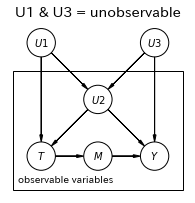

In [34]:
# @title (2) これは識別可能？
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U1", r"$U1$", 1, 3)
pgm.add_node("U2", r"$U2$", 2, 2)
pgm.add_node("U3", r"$U3$", 3, 3)
pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 2, 1)
pgm.add_node("Y", r"$Y$", 3, 1)

pgm.add_edge("U1", "T")
pgm.add_edge("U1", "U2")
pgm.add_edge("U2", "T")
pgm.add_edge("U2", "Y")
pgm.add_edge("U3", "U2")
pgm.add_edge("U3", "Y")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 3, 2], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U1 & U3 = unobservable")
plt.show()